<a href="https://colab.research.google.com/github/leeds1219/AI_Notes_and_Projects/blob/main/D2L_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
pip install d2l

# 14.3 Object Detection and Bounding Boxes

In [40]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [45]:
d2l.set_figsize()
img = d2l.plt.imread('../img/catdog.jpg')
d2l.plt.imshow(img);

AttributeError: ignored

In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [ ]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# 14.4 Anchor Boxes

In [42]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # Simplify printing accuracy

In [43]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [44]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

AttributeError: ignored

In [ ]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [ ]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [ ]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [ ]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [ ]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [ ]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

In [ ]:
labels[2]

In [ ]:
labels[1]

In [ ]:
labels[0]

In [ ]:
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [ ]:
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [ ]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted background likelihood
                      [0.9, 0.8, 0.7, 0.1],  # Predicted dog likelihood
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted cat likelihood

In [ ]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [ ]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

In [ ]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

# 14.7 Single Shot Multibox Detection (SSD)

Professor Kim's run

In [ ]:
# MXNet Install
!pip install mxnet-cu112  # Check compatibility with your CUDA version

# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive/')  # Mount Google Drive

# Change directory to Colab Notebooks
%cd '/content/drive/MyDrive/Colab Notebooks'

# Clone the GitHub repository
!git clone https://github.com/MLman/d2l-pytorch.git

# Change directory to the cloned repository
%cd '/content/drive/MyDrive/Colab Notebooks/d2l-pytorch/d2l'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks
fatal: destination path 'd2l-pytorch' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/d2l-pytorch/d2l


# **Model**

**Category Prediction Layer**

In [ ]:
pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
 

In [ ]:
%matplotlib inline
import sys
sys.path.insert(0, '..')
import d2l # d2l in colab need additional installations
# pip install d2l==1.0.3 #(change the versions)
# from d2l.ssd_utils import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import json
import time
from tqdm import tqdm
from PIL import Image
def cls_predictor(input_channels, num_anchors, num_classes):
    return nn.Conv2d(in_channels=input_channels, out_channels=num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)

**Bounding Box Prediction Layer**

In [ ]:
def bbox_predictor(input_channels, num_anchors):
    return nn.Conv2d(in_channels=input_channels, out_channels=num_anchors * 4, kernel_size=3, padding=1)

**Concatenating Predictions for Multiple Scales**

In [ ]:
def forward(x, block):
    return block(x)
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
(Y1.shape, Y2.shape)

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [ ]:
def flatten_pred(pred):
    return pred.permute(0, 2, 3, 1).reshape(pred.size(0),-1)

def concat_preds(preds):
    return torch.cat(tuple([flatten_pred(p) for p in preds]), dim=1)

In [ ]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

**Height and Width Downsample Block**

In [ ]:
def down_sample_blk(input_channels, num_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels=input_channels, out_channels=num_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(num_features=num_channels))
        blk.append(nn.ReLU())
        input_channels=num_channels
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2))
    blk = nn.Sequential(*blk)
    return blk

In [ ]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

**Base Network Block**

In [ ]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    blk = nn.Sequential(*blk)
    return blk

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

**The Complete Model**

In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)

    return blk

In [ ]:
import itertools
import math
def create_anchors(feature_map_sizes, steps, sizes):
    """Compute default box sizes with scale and aspect transform."""
    scale = 256.
    steps = [s / scale for s in steps]
    sizes = [s / scale for s in sizes]

    aspect_ratios = ((2,),)


    num_layers = len(feature_map_sizes)

    boxes = []
    for i in range(num_layers):
        fmsize = feature_map_sizes[i]
        for h, w in itertools.product(range(fmsize), repeat=2):
            cx = (w + 0.5)*steps[i]
            cy = (h + 0.5)*steps[i]
            s = sizes[i]
            boxes.append((cx, cy, s, s))

            s = sizes[i+1]
            boxes.append((cx, cy, s, s))

            s = sizes[i]
            for ar in aspect_ratios[i]:

#                 boxes.append((cx - (s * math.sqrt(ar))/2, cy - (s / math.sqrt(ar))/2, cx + (s * math.sqrt(ar))/2, cy + (s / math.sqrt(ar))/2))
#                 boxes.append((cx - (s / math.sqrt(ar))/2, cy - (s * math.sqrt(ar))/2, cx + (s / math.sqrt(ar))/2, cy + (s * math.sqrt(ar))/2))

                boxes.append((cx, cy, (s * math.sqrt(ar)), (s / math.sqrt(ar))))
                boxes.append((cx, cy, (s / math.sqrt(ar)), (s * math.sqrt(ar))))

    return torch.Tensor(boxes) # [8632, 4]

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = create_anchors((Y.size(2),), (256/Y.size(2),), size)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [ ]:
sizes = [[0.2*256, 0.272*256], [0.37*256, 0.447*256], [0.54*256, 0.619*256],
         [0.71*256, 0.79*256], [0.88*256, 0.961*256]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(TinySSD, self).__init__()

        input_channels_cls = 128
        input_channels_bbox = 128
        self.num_classes = num_classes

        self.blk = []
        self.cls = []
        self.bbox = []

        self.blk_0 = get_blk(0)
        self.blk_1 = get_blk(1)
        self.blk_2 = get_blk(2)
        self.blk_3 = get_blk(3)
        self.blk_4 = get_blk(4)

        self.cls_0 = cls_predictor(64, num_anchors, num_classes)
        self.cls_1 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_2 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_3 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_4 = cls_predictor(input_channels_cls, num_anchors, num_classes)

        self.bbox_0 = bbox_predictor(64, num_anchors)
        self.bbox_1 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_2 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_3 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_4 = bbox_predictor(input_channels_bbox, num_anchors)

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

        X, anchors[0], cls_preds[0], bbox_preds[0] = blk_forward(X, self.blk_0, sizes[0], ratios[0],
                                                                    self.cls_0, self.bbox_0)

        X, anchors[1], cls_preds[1], bbox_preds[1] = blk_forward(X, self.blk_1, sizes[1], ratios[1],
                                                                    self.cls_1, self.bbox_1)

        X, anchors[2], cls_preds[2], bbox_preds[2] = blk_forward(X, self.blk_2, sizes[2], ratios[2],
                                                                    self.cls_2, self.bbox_2)

        X, anchors[3], cls_preds[3], bbox_preds[3] = blk_forward(X, self.blk_3, sizes[3], ratios[3],
                                                                    self.cls_3, self.bbox_3)

        X, anchors[4], cls_preds[4], bbox_preds[4] = blk_forward(X, self.blk_4, sizes[4], ratios[4],
                                                                    self.cls_4, self.bbox_4)

        return (torch.cat(anchors, dim=0), concat_preds(cls_preds).reshape((-1, 5444, self.num_classes + 1)),
                concat_preds(bbox_preds))

In [ ]:
anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net = TinySSD(3, num_classes=1)
net.apply(init_weights)

X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


# **Training**

**Data Reading and Initialization**

In [ ]:
d2l.download_and_preprocess_data()

In [ ]:
batch_size = 32
data_dir = '../data/pikachu/'
train_dataset = d2l.PIKACHU(data_dir, 'train')
val_dataset = d2l.PIKACHU(data_dir, 'val')

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=4)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '7' # You can set gpu no. if you have multiple gpus

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [ ]:
net = TinySSD(3, num_classes=1)
net.apply(init_weights)
net = net.to(device)

learning_rate = 1e-3
weight_decay = 5e-4
optimizer = optim.SGD(net.parameters(), lr = learning_rate, weight_decay=weight_decay)

**Define Loss and Evaluation Functions**

In [ ]:
id_cat = dict()
id_cat[0] = 'pikachu'

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, device="cuda:0", eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

class SSDLoss(nn.Module):
    def __init__(self, loc_factor, jaccard_overlap, device = "cuda:0", **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap

        self.device = device

    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels]

    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true, anchors):
        loc_loss = 0.0
        class_loss = 0.0


        for i in range(len(class_true)):  # Batch level

            class_hat_i = class_hat[i, :, :]

            bb_true_i = bb_true[i].float()

            class_true_i = class_true[i]

            class_target = torch.zeros(class_hat_i.shape[0]).long().to(self.device)

            overlap_list = d2l.find_overlap(bb_true_i.squeeze(0), anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j].long()

                input_ = bb_hat[i, overlap, :]
                target_ = SSDLoss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(self.device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

**Train the Model**

In [ ]:
loss = SSDLoss(loc_factor=5.0, jaccard_overlap=0.5, device="cuda:0")

RuntimeError: ignored

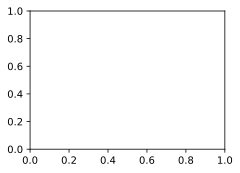

In [ ]:
num_epochs = 25
init_epoch = 0

# Uncomment the following 2 lines if you wish to load a pre-trained/saved model
#checkpoint_path = './ssd_outputs/model-29_0.1411931432526687.pth'   # Mention the model name to load
#init_epoch = d2l.load(net, checkpoint_path, optimizer)

animator = d2l.Animator(xlabel='epoch', xlim=[init_epoch+1, num_epochs],
                        legend=['class error', 'bbox mae', 'train_err'])

for epoch in range(init_epoch, num_epochs):

    net.train()

    train_loss = 0.0
    loc_loss = 0.0
    class_loss = 0.0

    for i, (x, bb_true, class_true) in (enumerate(train_loader)):

        x = x.to(device)
        bb_true = bb_true.to(device)
        class_true = class_true.to(device)

        timer_start = time.time()

        anchors, cls_preds, bbox_preds = net(x)

        class_true = [*class_true.reshape((class_true.size(0), 1, 1))]
        bb_true = [*bb_true.reshape((bb_true.size(0), 1, 1, 4))]

        bbox_preds = bbox_preds.reshape((-1, 5444, 4))

        # Label the category and offset of each anchor box
        anchors = anchors.to(device)

        batch_loss, batch_loc_loss, batch_class_loss = loss(cls_preds, bbox_preds, class_true, bb_true, anchors)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        class_loss += batch_class_loss
        loc_loss += batch_loc_loss
        train_loss += batch_loss

#     Uncomment the following 2 line for saving the model every epoch
#     path_to_checkpoints_dir = './ssd_outputs/'
#     d2l.save(net, path_to_checkpoints_dir, epoch, optimizer, train_loss/len(train_loader))

    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    loc_loss = (loc_loss/len(train_loader)).detach().cpu().numpy()
    class_loss = (class_loss/len(train_loader)).detach().cpu().numpy()

#     print(class_loss, loc_loss, train_loss, epoch+1)

    # Uncomment the following if you wish to see the results after every epoch to see the learning effect
    # Images will be saved to the 'results_every_epoch' directory

#     try:
#         d2l.infer(net, epoch, 0.9, device)
#     except Exception as e:
#         print(e, 'error' + str(epoch+1))
    animator.add(epoch, (class_loss, loc_loss, train_loss))

**Saving the final Model**

In [ ]:
path_to_checkpoints_dir = './ssd_outputs'
d2l.save(net, path_to_checkpoints_dir, epoch, optimizer, train_loss/len(train_loader))

**Prediction**

In [ ]:
img = np.array(Image.open('../img/pikachu.jpg').convert('RGB').resize((256, 256), Image.BILINEAR))
X = transforms.Compose([transforms.ToTensor()])(img).to(device)
X = X.to(device)

In [ ]:
def predict(X, nms_threshold):
    background_threshold = 0.8
    net.eval()
    anchors, class_hat, bb_hat = net(X.unsqueeze(0))
    anchors = anchors.to(device)
    bb_hat = bb_hat.reshape((1, -1, 4))
    bb_hat = d2l.invert_transformation(bb_hat.squeeze(0), anchors)
    bb_hat = bb_hat * 256.0

    class_hat = class_hat.sigmoid().squeeze(0)

    bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]


    bb_hat = bb_hat.detach().cpu().numpy()
    class_hat = class_hat[class_hat[:,0] < background_threshold, :]

    class_preds = class_hat[:, 1:]

    prob, class_id = torch.max(class_preds,1)

    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()



    output_bb = [d2l.PredBoundingBox(probability=1 - prob[i],
                                 class_id=class_id[i],
                                 classname=id_cat[class_id[i]],
                                 bounding_box=[bb_hat[i, 0],
                                               bb_hat[i, 1],
                                               bb_hat[i, 2],
                                               bb_hat[i, 3]])
                                 for i in range(0, len(prob))]

    output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=False)

    filtered_bb = d2l.non_max_suppression(output_bb, nms_threshold)

    return filtered_bb

filtered_bb = predict(X, 0.1)

In [ ]:
def display(img, output):

    img = d2l.draw_boxes(img, [bb.bounding_box for bb in filtered_bb])
    img = d2l.draw_text(img, [str(bb.probability)[:5] for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
    d2l.plt.imshow(img)
    d2l.plt.show()

display(img, filtered_bb)

**Summary**

**Exercises**

**Loss Function**

In [ ]:
sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = np.arange(-2, 2, 0.1)
d2l.set_figsize()

In [ ]:
def smooth_l1(x, scalar):
    a = []
    for i in x:

        if abs(i) < 1/((scalar)**2):
            a.append(((scalar*i)**2)/2)

        else:
            a.append(abs(i) - 0.5/((scalar)**2))

    return np.array(a)

In [ ]:
a1 = []
for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)

d2l.plt.legend();

In [ ]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * np.log(x)

x = np.arange(0.01, 1, 0.01)

for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l,
                     label='gamma=%.1f' % gamma)

d2l.plt.legend();

**Training and Prediction**